In [27]:
import yfinance as yf
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from plotnine import ggplot, geom_line, aes, theme_minimal, geom_tile, geom_label,\
                     scale_fill_distiller, labs, theme, element_text, geom_point,\
                     geom_ribbon

# This is the best implementation of Multivariate Singular Spectrum Analysis (mSSA)
# pip install git+https://github.com/AbdullahO/mSSA.git   
from mssa.mssa import mSSA


In [28]:
def makeLongTimeSeriesDf(timeSeriesDataFrame):
    return timeSeriesDataFrame.reset_index().melt(id_vars = 'Date').copy()

def makeTimeSeriesPlot(title,longTimeSeriesDataFrame):
    myPlot =  (
        ggplot(longTimeSeriesDataFrame.dropna(subset=["value"]))  
        + aes(x="Date", y="value",color = "Ticker")  
        + geom_line()  # Geometric object to use for drawing
        + labs(
            x = 'Date', 
            y = 'Share Price', 
            color = 'Tickers', 
            title = title)
        + theme(axis_text_x = element_text(rotation = 90, hjust = 0), figure_size = (12,6))
    )
    return myPlot


In [29]:
tickers = ['GOOG', 'NVDA','META','EQX']

today = dt.date.today()
lookback = today - relativedelta(years=10)


dataLookbackFull = yf.download(tickers, start=lookback, end=today, auto_adjust=True)['Close']
dataLookbackNoNa = dataLookbackFull.dropna(subset=["EQX"]).copy()
lengthFull = len(dataLookbackFull)
lengthNoNa = len(dataLookbackNoNa)
lastNaNum = lengthFull - lengthNoNa
title = "Time Series Plot Showing Closing Share Price for the lookback period before Data Imputation"
plotComplete = makeTimeSeriesPlot(title,makeLongTimeSeriesDf(dataLookbackFull))

[*********************100%%**********************]  4 of 4 completed


In [30]:
# We can need to take into account the correlations between the other assets in our portfolio when 
# We do imputation i.e. Multivariate time series imputation. One could use Vector Auto Regressive 
# Model. This is a regression that fits the entire time series and considers cross correlations
# In order to use VAR models, we would need to make all our time series stationery before we could
# Implement them. Hesitant to use a recurrent neural network (or any neural network) given the 
# their black box nature. Spatio-temporal factoring methods could be good here. There is a good 
# Python implementaion of Multivariate Singular Spectrum Analysis (mSSA). The spatial component 
# is the correlation across all the time series. Hoping that this can capture how the correlation 
# changes over time - markets tend to be more correlated during periods of market stress. Another 
# is that mSSA requires less prep time to make it work - VAR method must ensure that time series is 
# an autoregressive process via transformations. VAR just seems like a lot of work for an interview
# question. Will investigate all possible methods a later date when I have time. 

In [31]:
model = mSSA(fill_in_missing = True)
model.update_model(dataLookbackFull.reset_index(drop=True))

indexVals = dataLookbackFull.index.values
predictions = np.ones((lengthFull,3))
for ix in range(lengthFull):
    predictions[ix,:] = model.predict('EQX',ix,confidence=99).values

predictions = pd.DataFrame(predictions, columns=['EQX_Predicted', 'Upper_Conf','Lower_Conf'], index=dataLookbackFull.index)
predictions.columns.name = 'Ticker'
longPredictions = makeLongTimeSeriesDf(predictions)
df = makeLongTimeSeriesDf(dataLookbackFull)
longActual = df[df.Ticker == 'EQX']
predictionsAndActual = pd.concat([longActual,longPredictions],axis=0)

plotEQX = (
    ggplot(data=predictions.reset_index()) # we can override this data later
    +geom_line(aes(x = 'Date', y = 'value',color = 'Ticker'), data=longPredictions)
    +geom_point(aes(x = 'Date', y = 'value',color = 'Ticker'),alpha = 0.5, size = 0.1, data=longActual.dropna())
    +geom_ribbon(aes(x = 'Date',ymin='Lower_Conf', ymax="Upper_Conf"),alpha = 0.5, fill="#0294a55e")
    + labs(
        x = 'Date', 
        y = 'Share Price', 
        color = 'Tickers', 
        title = "The Share Price for EQX with the Spacial-Temporal Imputed Values",
        subtitle = 'The Multivariate Singular Spectrum Analysis Algorithm captures the drift and volatility regime shift implied by the other assets in the portfolio')
+ theme(axis_text_x = element_text(rotation = 90, hjust = 0), figure_size = (12,6))
)

The component VaR shows the reduction of the portfolio value-at-risk resulting from removal of a position. The sum of component VaR of the shares in the portfolio equals the portfolio diversified VaR.

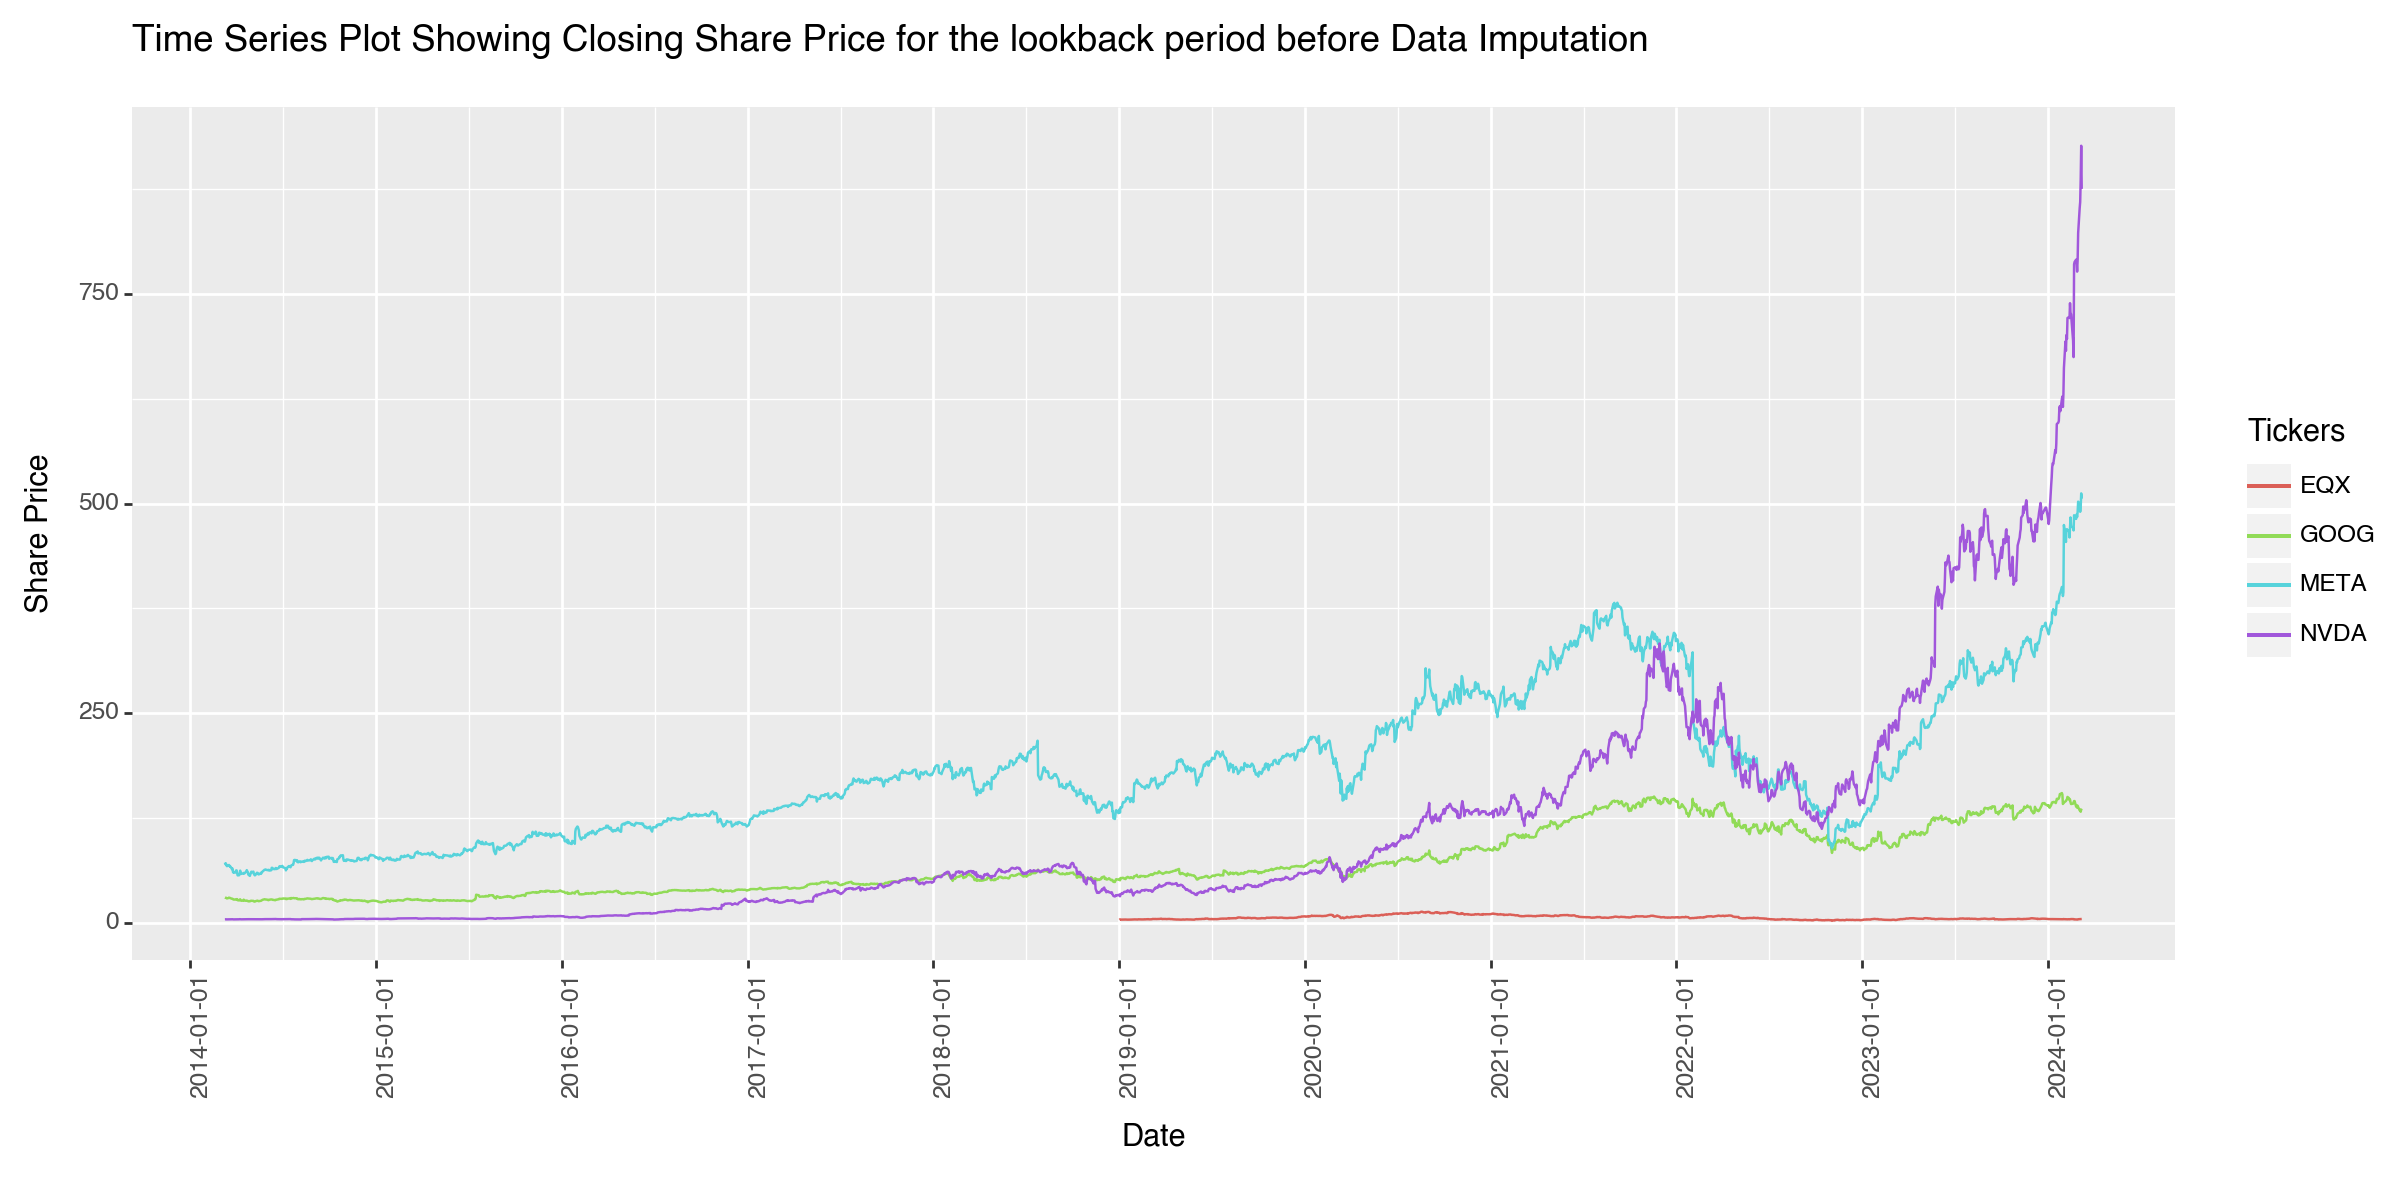

<Figure Size: (1200 x 600)>

In [32]:
plotComplete

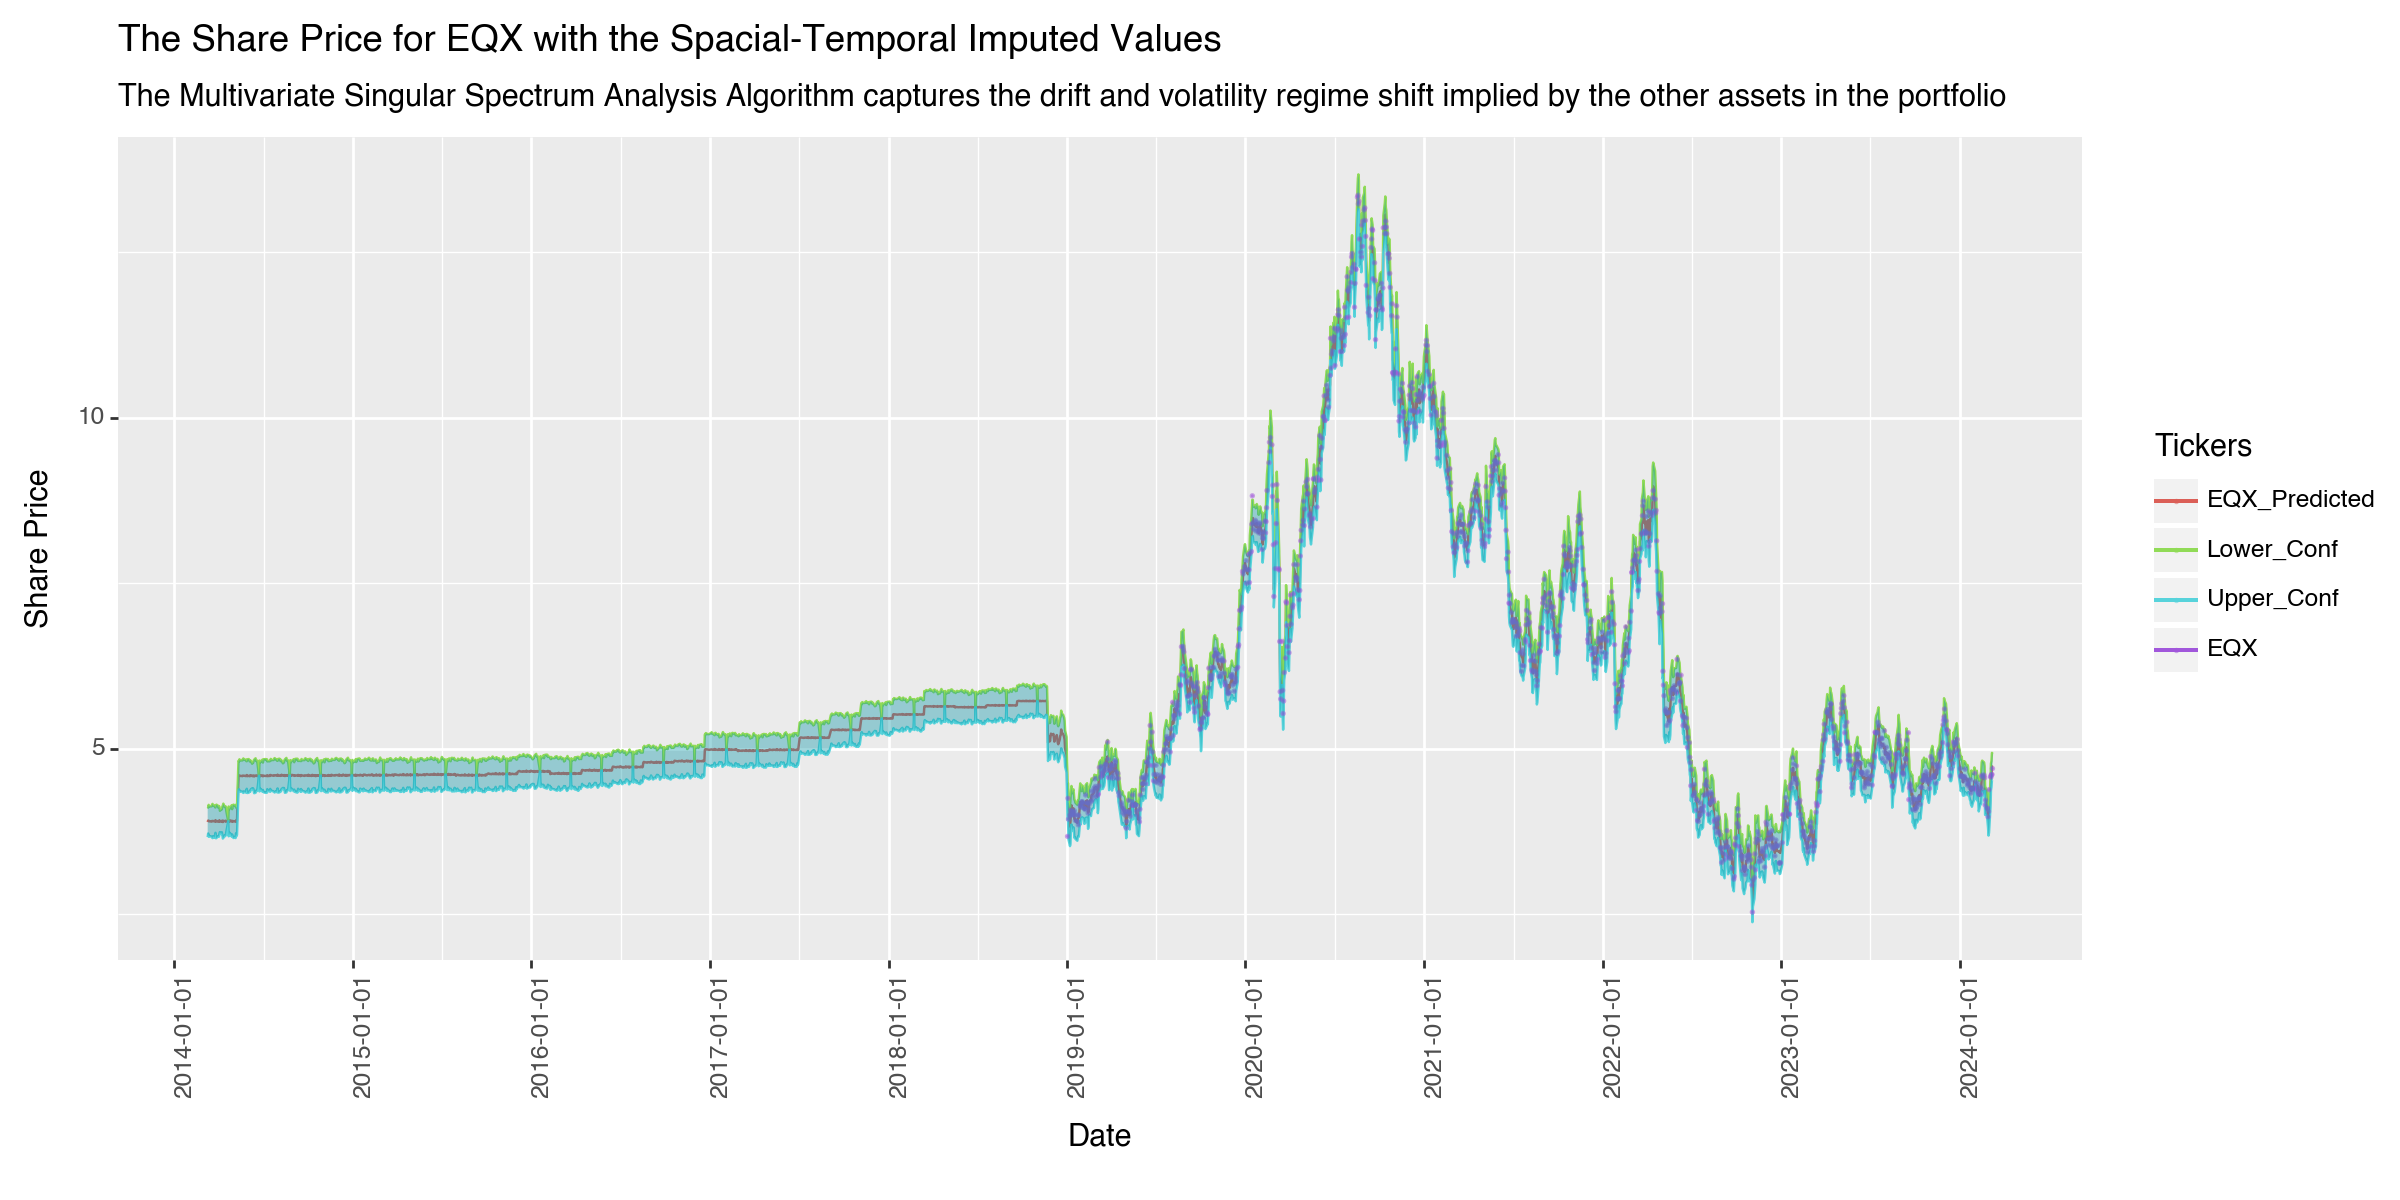

<Figure Size: (1200 x 600)>

In [33]:
plotEQX